The intention is to create a data set of light curves, for varying values of signal-to-noise ratio and number of transits, represented in three different formats (sonifications, plots and videos). These will form the basis of A/B/C user testing.

[Section 1](#section_1) - importing modules and formatting the Jupyter notebook. 

[Section 2](#section_2) - choosing the parameters we want to generate light curves for.

[Section 3](#section_3) - using astronify to generate an example curve, and representing this both visually using matplotlib and sonifying with astronify.

[Section 4](#section_4) - building the dataset for the parameters we set in section 2.

[Section 5](#section_5) - saving a database containing information about the curves we've produced.

Reach me at b9058149@ncl.ac.uk

# Preamble

We'll start by formatting the notebook, and importing the Python modules required. <a id=’section_1’></a> 

In [19]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import matplotlib
import matplotlib.pyplot as plt # For plots and visual data
import lightkurve as lk # Used in conjunction with astronify for creating our light curve data
import numpy as np
import os
import pandas as pd
import jupyterthemes
import math
import random
import sys
import datetime
import os.path
from os.path import abspath

from astronify.series import SoniSeries # For sonifying the data
from astropy.io import fits
from astropy.table import Table
from pandas.plotting import table
from astronify import simulator, series
from pathlib import Path
matplotlib.rcParams.update({'font.size': 22})

# Setting light curve parameters

Here, we'll set some parameters for the curves we want to produce. The code is currently set for six values of signal-to-noise, and three values for the number of transits (0, 1 and 2, note 0 transit curves are done separately) so 18 curves will be generated. 

From the values of SNR we want to test at, we can obtain a value for the corresponding standard deviation of noise which is calculated depending on the transits width and depth (see report for more detail on this). This is what astronify takes as input for it's noise parameter. We can also obtain a distance between transits which I've called freq_param. This equates to 1000 for curves of one transit, and 500 for curves of two. <a id=’section_2’></a> 

In [5]:
snr = [3,5,7,10,30,100] # The signal to noise ratio we are testing for
transit_length = 1000 # Affects length of sonification, we wanted to keep this at about 10 seconds and 1000 was appropriate
t_depth = 25 # The depth of the transit as a percentage of the brightness flux
width_param = 0.1 # Transit length as fraction of total
transit_n = [1,2] # Number of transits we want in the data
t_width = transit_length*width_param # In our case, 100

noise_sd = [] # The actual noise sigma values for astronify
for x in snr:
    noise_sd.append(np.sqrt(t_width)*t_depth/x) 
    
freq_param = [] # Distance between transits (this doesn't apply to curve of no transits).
for x in transit_n:
    freq_param.append(int(transit_length/x)) 

In [6]:
"Standard deviations of noise to put in are:" ,noise_sd

('Standard deviations of noise to put in are:',
 [83.33333333333333, 50.0, 35.714285714285715, 25.0, 8.333333333333334, 2.5])

In [7]:
"Transit periods:", freq_param

('Transit periods:', [1000, 500])

# Generating an example transit with noise and no noise

Now we're ready to start using astronify to generate transit light curves. To get a sense of how our curves look, we'll start with a curve of one transit (presented both with noise and without), using this formula t_start to randomize the position of the transit (this also avoids it being directly at the start or the end of the curve, which would be unfairly difficult to identify in a sonification). Astronify has also been used in the noisy transit to sonify and play the data with a given set of parameters for the actual sonification. We were informed on these by the developers (https://astronify.readthedocs.io/en/latest/astronify/Intro_Astronify_Series.html#changing-sonification-parameters). 

You will notice by running this next cell multiple times that the start of the transit will be at a different place each time (note you can also change n_transit and experiment with curves of a different number of transits). Please note therefore that due to the randomness of the transit starts, the generated dataset won't be exactly the same as the one with which I carried out the user testing.

Saving to the system is currently commented out. <a id=’section_3’></a> 

Text(0, 0.5, 'Brightness flux (arbitrary units)')

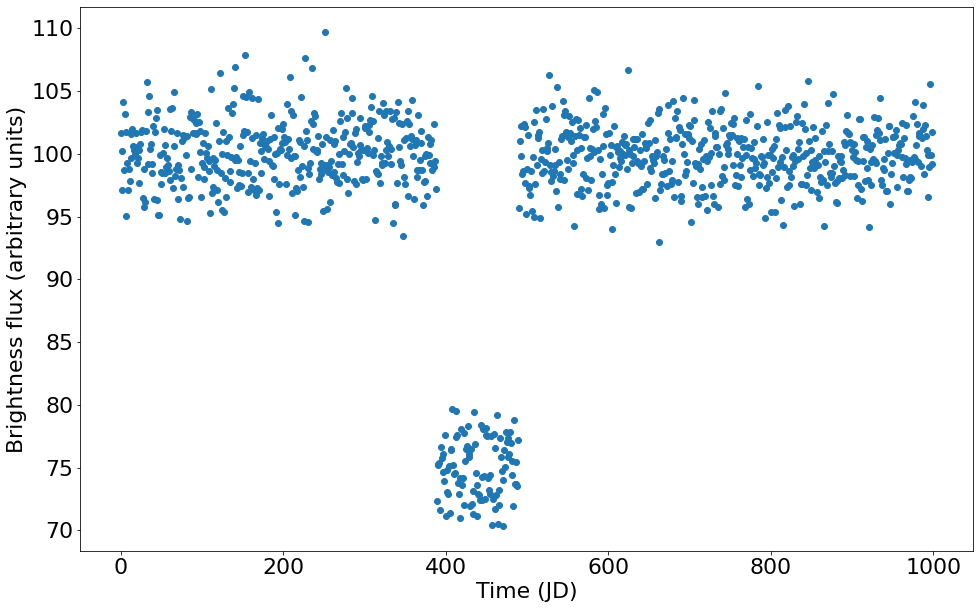

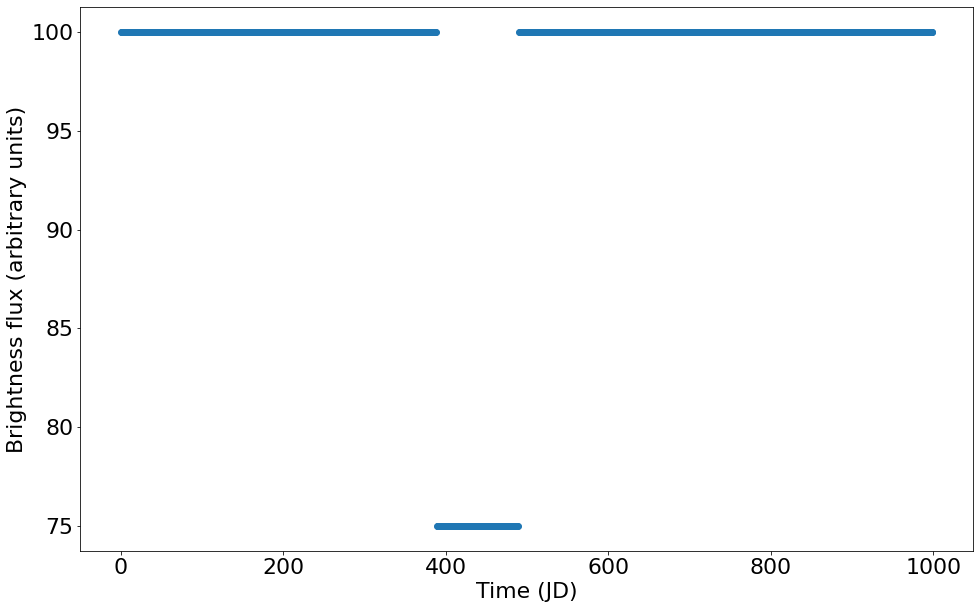

In [9]:
n_transit = 1
t_period = int(transit_length/n_transit) # Analogous to freq_param - just used a single variable here instead of freq_param which is a list.
t_start = int(transit_length/(2.*n_transit)-t_width/2. + random.randint(-1*t_period/4, t_period/4)) # Randomizes the transit start within a given range.

lc_data_noise = simulator.simulated_lc("transit", visualize=False, 
                                       transit_depth=int(t_depth), transit_period=t_period,
                                       transit_width=int(t_width), lc_noise=2.5, # Noise value of 2.5 corresponds to 100 SNR.
                                       lc_length=int(transit_length),transit_start=t_start)

f, ax = plt.subplots(figsize=(16, 10)) # Producing a figure of the light curve
ax.plot(lc_data_noise['time'], lc_data_noise['flux'],'-o', linewidth=0)
ax.set_xlabel("Time (JD)")
ax.set_ylabel("Brightness flux (arbitrary units)")

lc_sound_transit = series.SoniSeries(lc_data_noise) # Sonifying the light curve
lc_sound_transit.pitch_mapper.pitch_map_args["stretch"] = 'linear'
lc_sound_transit.pitch_mapper.pitch_map_args["pitch_range"] = [440,880]
lc_sound_transit_spacing = 0.01
lc_sound_transit.note_duration = 0.2
lc_sound_transit.sonify()

#lc_sound_transit.play()
#plt.savefig("Example noisy transit.png")

lc_data_noiseless = simulator.simulated_lc("transit", visualize=False, 
                                           transit_depth=int(t_depth), transit_period=t_period,
                                           transit_width=int(t_width), lc_noise=0, 
                                           lc_length=int(transit_length),transit_start=t_start)

f, ax = plt.subplots(figsize=(16, 10))
ax.plot(lc_data_noiseless['time'], lc_data_noiseless['flux'],'-o', linewidth=0)
ax.set_xlabel("Time (JD)")
ax.set_ylabel("Brightness flux (arbitrary units)")

#plt.savefig("Example noiseless transit.png")

# Light curve generator

Great! We're able to produce light curves using astronify and represent them both visually and in sonification form. <a id=’section_4’></a> 

## Building database of the parameters for reference

For generating a test dataset, we'll start by building a database of light curves and their parameters. As we need to refer back to the properties of these curves after the user testing, this database will contain the number of transits that curve has, and the value of signal-to-noise used. As each curve is unique, we'll assign a 'tag' to each - this is so that after the user testing period we can cross reference back to each curve.

Please note if you run the cells in sections 4.2 and 4.3 multiple times, you'll need to go back and rerun this cell to start with a fresh database. <a id=’section_4.1’></a> 

In [10]:
if 'df' in locals(): # Making sure we start with an empty database.
    del df
    
df = pd.DataFrame({'Number of transits': [],
                   'Value of SNR': [],
                   'Tag': []})
display(df)

,Number of transits,Value of SNR,Tag


## Curves with 1 and 2 transits

To produce a database of curves, I'm running an iterative loop over the number of transits (1 and 2, 0 transit curves are separate) and the values of signal-to-noise. So we can tell exactly what the generator is doing we'll also create a plot of the noiseless version of the same curve for reference.

The actual code here is relatively simple - the important part is that k represents a unique, randomized tag, that is assigned to each curve. This is so the curves are 'anonymous' to users (i.e. when users are completing the testing, the SNR and number of transits are not in the name of each curve they're hearing/looking at), hence why having the database to refer back to each curves' properties is so essential.

Note the relevant code for saving the sonifications and plots to the system is currently commented out. <a id=’section_4.2’></a> 

In [12]:
for j in transit_n:
                   
    for i in noise_sd:
        
        # Running the same t_start formula from the examples, but for the two elements in transit_n, [1,2].
        t_start = int(transit_length/(2.*j)-(transit_length*width_param)/2. + 
                      random.randint(-1*(transit_length/j)/4, (transit_length/j)/4)) 
        
        k = int(random.uniform(5*len(df),(5*len(df)+4))) # k is related to the iteration of the for loop, so is unique.
        
        lc_data_transit = simulator.simulated_lc("transit", # The actual curve we'll use
                                         visualize = False, 
                                         transit_depth = t_depth,
                                         transit_period = transit_length/j, 
                                         transit_width = int(t_width),
                                         transit_start = t_start,
                                         lc_noise = i, 
                                         lc_length = transit_length) 
        
        lc_data_transit0 = simulator.simulated_lc("transit", # A noiseless version of the same transit
                                         visualize = False, 
                                         transit_depth = t_depth,
                                         transit_period = transit_length/j, 
                                         transit_width = int(t_width),
                                         transit_start = t_start,
                                         lc_noise = 0, 
                                         lc_length = transit_length) 


        lc_sound_transit = series.SoniSeries(lc_data_transit) # Sonifying the data, same sonification parameters as before
        lc_sound_transit.pitch_mapper.pitch_map_args["stretch"] = 'linear'
        lc_sound_transit.pitch_mapper.pitch_map_args["pitch_range"] = [440,880]
        lc_sound_transit_spacing = 0.01
        lc_sound_transit.note_duration = 0.2
        lc_sound_transit.sonify()

        #lc_sound_transit.write("sonification" + str(k) + ".wav")
        #--------------------------------------------------------------------------------------------------------------------
        f, ax = plt.subplots(figsize=(12, 6)) # Creating a plot
        ax.plot(lc_data_transit['time'], lc_data_transit['flux'],'-o', linewidth=0)
        ax.set_xlabel("Time (JD)")
        ax.set_ylabel("Flux")
        #plt.savefig("plot" + str(k) + ".jpg") 
        plt.close()
        
        df = df.append({'Number of transits':int(j), # Adding the properties of the curve we've produced to our database, with it's unique tag
                        'Value of SNR':math.ceil((t_depth*np.sqrt(t_width))/i),
                        'Tag':k},
                        ignore_index=True) 
        #-------------------------------------------------------------------------------------------------------------------
        f, ax = plt.subplots(figsize=(12, 6)) # Plot of the noiseless version
        ax.plot(lc_data_transit0['time'], lc_data_transit0['flux'],'-o', linewidth=0)
        ax.set_xlabel("Time (JD)")
        ax.set_ylabel("Flux")
        #plt.savefig("plot" + str(k) + "noiseless.jpg")
        plt.close()
        
"Generation of non-zero transit data finished"

'Generation of non-zero transit data finished'

Double checking that the database has a unique curve for each value of signal-to-noise and number of transits.

In [13]:
display(df)

,Number of transits,Value of SNR,Tag
0,1.0,3.0,3.0
1,1.0,5.0,7.0
2,1.0,7.0,10.0
3,1.0,10.0,17.0
4,1.0,30.0,22.0
5,1.0,100.0,25.0
6,2.0,3.0,32.0
7,2.0,5.0,35.0
8,2.0,7.0,42.0
9,2.0,10.0,46.0


## Curves of zero transits

Now we just need to generate curves of zero transits for each value of SNR. We'll do this by using astronify's 'flat' type of curve for each value of noise we require, and then appending their information and tags to the database as before. <a id=’section_4.3’></a> 

In [14]:
for i in noise_sd: 

        j = int(random.uniform(5*len(df),(5*len(df)+4)))  
    
        lc_data_transit = simulator.simulated_lc("flat", 
                                         visualize = False, 
                                         transit_depth = t_depth,
                                         transit_period = transit_length,
                                         transit_width = int(t_width),
                                         lc_noise = i, 
                                         lc_length = transit_length)


        lc_sound_transit = series.SoniSeries(lc_data_transit)
        lc_sound_transit.pitch_mapper.pitch_map_args["stretch"] = 'linear'
        lc_sound_transit.pitch_mapper.pitch_map_args["pitch_range"] = [440,880]
        lc_sound_transit_spacing = 0.01
        lc_sound_transit.note_duration = 0.2
        lc_sound_transit.sonify()
        #lc_sound_transit.write("sonification" + str(j) + ".wav")
        #--------------------------------------------------------------------------------------------------------------------
        f, ax = plt.subplots(figsize=(12, 6))
        ax.plot(lc_data_transit['time'], lc_data_transit['flux'],'-o', linewidth=0)
        ax.set_xlabel("Time (JD)")
        ax.set_ylabel("Flux")
        #plt.savefig("plot" + str(j) + ".jpg")
        plt.close()

        df = df.append({'Number of transits':0,
                      'Value of SNR':math.ceil((25*np.sqrt(transit_length*width_param))/i),
                      'Tag':j},
                      ignore_index=True)

"Generation of zero transit data finished"

'Generation of zero transit data finished'

We should now have all the curves we require, so in my case 6 different values of SNR, 3 different numbers of transits, and unique random tags for each curve. If there's more/less curves than expected, try re-running the code up to here from 4.1.

In [15]:
display(df)

,Number of transits,Value of SNR,Tag
0,1.0,3.0,3.0
1,1.0,5.0,7.0
2,1.0,7.0,10.0
3,1.0,10.0,17.0
4,1.0,30.0,22.0
5,1.0,100.0,25.0
6,2.0,3.0,32.0
7,2.0,5.0,35.0
8,2.0,7.0,42.0
9,2.0,10.0,46.0


## Writing ffmpeg files

We now have 18 curves, that are saved in two different formats. Lastly, to generate a full database of 54 test data sets as orignally intended, we need to essentially stitch together a curve's sonification to it's corresponding plot. We'll do this using ffmpeg (this will need to be installed on your system for this section to work). https://www.wikihow.com/Install-FFmpeg-on-Windows. 

The sonifications and plots will have saved to the directory you're running this notebook from. Once you've installed ffmpeg, you'll need to copy the sonifications and plots into two separate folders in the notebook directory, then copy these two folders into the ffmpeg directory (e.g. C:\ffmpeg). Then create an output folder for the videos, so you have all the sonifications saved in e.g. C:\ffmpeg\sonifications, plots in C:\ffmpeg\plots, and an empty folder where the videos will save (the code below has this called 'out').

The command below will then run an ffmpeg command in the console to put together corresponding sonifications and plots. 'string' is what gets sent to the console - so if you've used different directories you'll need to change this in the string. <a id=’section_4.4’></a> 

In [ ]:
import ffmpeg

In [62]:
for i in df['Tag']: 

    og_string = str(i)
    size = len(og_string)
    tag = og_string[:size - 2] # Tag numbers are saved as integers in the database, so convert these to a string and slice off the '.0' at the end.
    print(tag)
    text_file = open("new.cmd", "w") # Open a command file, which we'll write the string to.
    
    string = "C:\\ffmpeg\\bin\\ffmpeg -loop 1 -i C:\\ffmpeg\\plots\\plot"+tag+".jpg -i C:\\ffmpeg\\sonifications\\sonification"+tag+".wav -c:v libx264 -tune stillimage -c:a aac -b:a 192k -pix_fmt yuv420p -shortest C:\\ffmpeg\\combined\\out"+tag+".mp4 "
    text_file.write(string) # Write string which is a terminal command to the .cmd file. 
    text_file.close()
    
    ! new.cmd # Run the terminal command, for each tag number in the database, i.e. run ffmpeg for each sonification and it's plot.

ffmpeg version 2021-02-28-git-85ab9deb98-full_build-www.gyan.dev Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10.2.0 (Rev6, Built by MSYS2 project)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-libxml2 --enable-gmp --enable-lzma --enable-libsnappy --enable-zlib --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-libbluray --enable-libcaca --enable-sdl2 --enable-libdav1d --enable-libzvbi --enable-librav1e --enable-libsvtav1 --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-libaom --enable-libopenjpeg --enable-libvpx --enable-libass --enable-frei0r --enable-libfreetype --enable-libfribidi --enable-libvidstab --enable-libvmaf --enable-libzimg --enable-amf --enable-cuda-llvm --enable-cuvid --enable-ffnvcodec --enable-nvdec --enable-nvenc --enable-d3d11va --enable-dxva2 --enable-libmfx --enable-libglslang 

ffmpeg version 2021-02-28-git-85ab9deb98-full_build-www.gyan.dev Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10.2.0 (Rev6, Built by MSYS2 project)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-libxml2 --enable-gmp --enable-lzma --enable-libsnappy --enable-zlib --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-libbluray --enable-libcaca --enable-sdl2 --enable-libdav1d --enable-libzvbi --enable-librav1e --enable-libsvtav1 --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-libaom --enable-libopenjpeg --enable-libvpx --enable-libass --enable-frei0r --enable-libfreetype --enable-libfribidi --enable-libvidstab --enable-libvmaf --enable-libzimg --enable-amf --enable-cuda-llvm --enable-cuvid --enable-ffnvcodec --enable-nvdec --enable-nvenc --enable-d3d11va --enable-dxva2 --enable-libmfx --enable-libglslang 

ffmpeg version 2021-02-28-git-85ab9deb98-full_build-www.gyan.dev Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10.2.0 (Rev6, Built by MSYS2 project)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-libxml2 --enable-gmp --enable-lzma --enable-libsnappy --enable-zlib --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-libbluray --enable-libcaca --enable-sdl2 --enable-libdav1d --enable-libzvbi --enable-librav1e --enable-libsvtav1 --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-libaom --enable-libopenjpeg --enable-libvpx --enable-libass --enable-frei0r --enable-libfreetype --enable-libfribidi --enable-libvidstab --enable-libvmaf --enable-libzimg --enable-amf --enable-cuda-llvm --enable-cuvid --enable-ffnvcodec --enable-nvdec --enable-nvenc --enable-d3d11va --enable-dxva2 --enable-libmfx --enable-libglslang 

ffmpeg version 2021-02-28-git-85ab9deb98-full_build-www.gyan.dev Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10.2.0 (Rev6, Built by MSYS2 project)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-libxml2 --enable-gmp --enable-lzma --enable-libsnappy --enable-zlib --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-libbluray --enable-libcaca --enable-sdl2 --enable-libdav1d --enable-libzvbi --enable-librav1e --enable-libsvtav1 --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-libaom --enable-libopenjpeg --enable-libvpx --enable-libass --enable-frei0r --enable-libfreetype --enable-libfribidi --enable-libvidstab --enable-libvmaf --enable-libzimg --enable-amf --enable-cuda-llvm --enable-cuvid --enable-ffnvcodec --enable-nvdec --enable-nvenc --enable-d3d11va --enable-dxva2 --enable-libmfx --enable-libglslang 

ffmpeg version 2021-02-28-git-85ab9deb98-full_build-www.gyan.dev Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10.2.0 (Rev6, Built by MSYS2 project)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-libxml2 --enable-gmp --enable-lzma --enable-libsnappy --enable-zlib --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-libbluray --enable-libcaca --enable-sdl2 --enable-libdav1d --enable-libzvbi --enable-librav1e --enable-libsvtav1 --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-libaom --enable-libopenjpeg --enable-libvpx --enable-libass --enable-frei0r --enable-libfreetype --enable-libfribidi --enable-libvidstab --enable-libvmaf --enable-libzimg --enable-amf --enable-cuda-llvm --enable-cuvid --enable-ffnvcodec --enable-nvdec --enable-nvenc --enable-d3d11va --enable-dxva2 --enable-libmfx --enable-libglslang 

[libx264 @ 0000029773caadc0] frame B:232   Avg QP: 9.67  size:    25
[libx264 @ 0000029773caadc0] consecutive B-frames:  1.0%  0.6%  0.0% 98.4%
[libx264 @ 0000029773caadc0] mb I  I16..4: 55.2%  6.0% 38.8%
[libx264 @ 0000029773caadc0] mb P  I16..4:  0.1%  0.0%  0.0%  P16..4:  0.1%  0.0%  0.0%  0.0%  0.0%    skip:99.8%
[libx264 @ 0000029773caadc0] mb B  I16..4:  0.0%  0.0%  0.0%  B16..8:  0.0%  0.0%  0.0%  direct: 0.0%  skip:100.0%  L0:88.6% L1:11.4% BI: 0.0%
[libx264 @ 0000029773caadc0] 8x8 transform intra:5.9% inter:70.5%
[libx264 @ 0000029773caadc0] coded y,uvDC,uvAC intra: 28.6% 34.8% 33.3% inter: 0.0% 0.0% 0.0%
[libx264 @ 0000029773caadc0] i16 v,h,dc,p: 76% 17%  7%  0%
[libx264 @ 0000029773caadc0] i8 v,h,dc,ddl,ddr,vr,hd,vl,hu: 59% 17% 20%  1%  1%  1%  1%  1%  1%
[libx264 @ 0000029773caadc0] i4 v,h,dc,ddl,ddr,vr,hd,vl,hu: 31% 17% 16%  5%  7%  6%  6%  6%  6%
[libx264 @ 0000029773caadc0] i8c dc,h,v,p: 81%  8%  7%  4%
[libx264 @ 0000029773caadc0] Weighted P-Frames: Y:0.0% UV:0.0%
[libx

ffmpeg version 2021-02-28-git-85ab9deb98-full_build-www.gyan.dev Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10.2.0 (Rev6, Built by MSYS2 project)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-libxml2 --enable-gmp --enable-lzma --enable-libsnappy --enable-zlib --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-libbluray --enable-libcaca --enable-sdl2 --enable-libdav1d --enable-libzvbi --enable-librav1e --enable-libsvtav1 --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-libaom --enable-libopenjpeg --enable-libvpx --enable-libass --enable-frei0r --enable-libfreetype --enable-libfribidi --enable-libvidstab --enable-libvmaf --enable-libzimg --enable-amf --enable-cuda-llvm --enable-cuvid --enable-ffnvcodec --enable-nvdec --enable-nvenc --enable-d3d11va --enable-dxva2 --enable-libmfx --enable-libglslang 

[libx264 @ 000001205be6ac80] coded y,uvDC,uvAC intra: 27.6% 33.4% 32.0% inter: 0.0% 0.0% 0.0%
[libx264 @ 000001205be6ac80] i16 v,h,dc,p: 80% 13%  7%  0%
[libx264 @ 000001205be6ac80] i8 v,h,dc,ddl,ddr,vr,hd,vl,hu: 62%  7% 26%  1%  1%  1%  1%  1%  1%
[libx264 @ 000001205be6ac80] i4 v,h,dc,ddl,ddr,vr,hd,vl,hu: 29% 15% 20%  5%  7%  7%  7%  6%  6%
[libx264 @ 000001205be6ac80] i8c dc,h,v,p: 82%  7%  6%  4%
[libx264 @ 000001205be6ac80] Weighted P-Frames: Y:0.0% UV:0.0%
[libx264 @ 000001205be6ac80] ref P L0: 71.3% 25.7%  2.9%
[libx264 @ 000001205be6ac80] kb/s:75.89
[aac @ 000001205c0fff40] Qavg: 65196.758
ffmpeg version 2021-02-28-git-85ab9deb98-full_build-www.gyan.dev Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10.2.0 (Rev6, Built by MSYS2 project)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-libxml2 --enable-gmp --enable-lzma --enable-libsnappy --enable-

ffmpeg version 2021-02-28-git-85ab9deb98-full_build-www.gyan.dev Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10.2.0 (Rev6, Built by MSYS2 project)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-libxml2 --enable-gmp --enable-lzma --enable-libsnappy --enable-zlib --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-libbluray --enable-libcaca --enable-sdl2 --enable-libdav1d --enable-libzvbi --enable-librav1e --enable-libsvtav1 --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-libaom --enable-libopenjpeg --enable-libvpx --enable-libass --enable-frei0r --enable-libfreetype --enable-libfribidi --enable-libvidstab --enable-libvmaf --enable-libzimg --enable-amf --enable-cuda-llvm --enable-cuvid --enable-ffnvcodec --enable-nvdec --enable-nvenc --enable-d3d11va --enable-dxva2 --enable-libmfx --enable-libglslang 

# Writing the dataframe to a file for reference.

Finally, we'll just write the database to a text file. <a id=’section_5’></a> 

In [22]:
display(df)
np.savetxt(r'np.txt', df, fmt='%d')

,Number of transits,Value of SNR,Tag
0,1.0,3.0,3.0
1,1.0,5.0,7.0
2,1.0,7.0,10.0
3,1.0,10.0,17.0
4,1.0,30.0,22.0
5,1.0,100.0,25.0
6,2.0,3.0,32.0
7,2.0,5.0,35.0
8,2.0,7.0,42.0
9,2.0,10.0,46.0
